<a href="https://colab.research.google.com/github/GGpark1/Deep_Learning_Study/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EB%B0%8F%20%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다층 퍼셉트론과 DTM으로 텍스트 분류하기

In [226]:
#모듈 import

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [227]:
newsdata_train = fetch_20newsgroups(subset = 'train')
newsdata_test = fetch_20newsgroups(subset = 'test')

In [275]:
#feature 확인

print(newsdata_train.data[88])

From: hammerl@acsu.buffalo.edu (Valerie S. Hammerl)
Subject: Re: Goalie Mask Update
Organization: UB
Lines: 19
Nntp-Posting-Host: lictor.acsu.buffalo.edu

In article <93289@hydra.gatech.EDU> gtd597a@prism.gatech.EDU (Hrivnak) writes:
>
>	Here are the results after three days of voting. Remember 3pts for 
>1st, 2 for 2nd, and 1 for 3rd. Also, you can still turn in votes! And.. if
>the guy isn't a regular goalie or he is retired, please include the team! 
>Thanks for your time, and keep on sending in those votes!

> Glenn Healy (NYI), Tommy Soderstron (???), Ray LeBlanc (USA).
                     ^^^^^^^^^^^^^^^^^^^^^^

Soderstrom plays with Philly, but he doesn't have a moulded mask.
He's got the helmet and cage variety, in white.  Or at least that's
what he wore thirteen hours ago.

-- 
Valerie Hammerl			"Some days I have to remind him he's not 
hammerl@acsu.buffalo.edu	Mario Lemieux."  Herb Brooks on Claude
acscvjh@ubms.cc.buffalo.edu	Lemieux, top scorer for the Devils, but 
v085pwwp

In [229]:
#타겟 데이터 클래스 수 확인

print(f"타겟 클래수 수 : {len(set(newsdata_train.target))}")
print(f"타겟 이름 : {newsdata_train.target_names}")

타겟 클래수 수 : 20
타겟 이름 : ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [230]:
#dataFrame 구성

df = pd.DataFrame(newsdata_train.data, columns = ['text'])
df['target'] = pd.Series(newsdata_train.target)
df.head()

,text,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [231]:
import re

df['text'] = df['text'].str.replace(':', '')
df['text'] = df['text'].str.replace('@', ' ')
df['text'] = df['text'].str.replace('.', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [232]:
df

,text,target
0,From lerxst wam umd edu (where's my thing)\nSu...,7
1,From guykuo carson u washington edu (Guy Kuo)\...,4
2,From twillis ec ecn purdue edu (Thomas E Willi...,4
3,From jgreen amber (Joe Green)\nSubject Re Weit...,1
4,From jcm head-cfa harvard edu (Jonathan McDowe...,14
...,...,...
11309,From jim zisfein factory com (Jim Zisfein) \nS...,13
11310,From ebodin pearl tufts edu\nSubject Screen De...,4
11311,From westes netcom com (Will Estes)\nSubject M...,3
11312,From steve hcrlgw (Steven Collins)\nSubject Re...,1


In [233]:
STOP_WORDS = nlp.Defaults.stop_words.union(['0', '1', '2', '3', '4', '5', '6', '7','8', '9' '', 'com', r"[^a-z0-9]"])

In [263]:
#불용어 적용
#토큰화


def tokenize(text):
    tokens = []

    for doc in tokenizer.pipe(df['text']):
        doc_tokens = []
        temp_token = [re.sub(r"[^a-z0-9]", "", token.text.lower()) for token in doc]

        for token in temp_token:
            if token not in STOP_WORDS:
                if len(token) != 0:
                    doc_tokens.append(token)

        tokens.append(doc_tokens)
        
    return tokens

"""
#불용어 적용
#토큰화
#표제어 적용(시간 오래 걸림)


def get_lemmas(text):
    lemmas = []
    
    doc = nlp(text)

    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            if len(token) != 0:
                lemmas.append(token.lemma_)
    
    return lemmas

"""

"\n#불용어 적용\n#토큰화\n#표제어 적용(시간 오래 걸림)\n\n\ndef get_lemmas(text):\n    lemmas = []\n    \n    doc = nlp(text)\n\n    for token in doc:\n        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):\n            if len(token) != 0:\n                lemmas.append(token.lemma_)\n    \n    return lemmas\n\n"

In [265]:
df['text_token'] = tokenize(df['text'])

In [268]:
from collections import Counter

word_counts = Counter()
df['text_token'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('edu', 20947),
 ('subject', 12253),
 ('lines', 11824),
 ('organization', 11194),
 ('writes', 7836),
 ('article', 6754),
 ('x', 5868),
 ('people', 5845),
 ('dont', 5828),
 ('like', 5768)]

In [251]:
def word_count(docs):
    """
    토큰화된 문서들을 입력받아 토큰별로 개수를 카운트 하고 관련된 속성을 가진 데이터프레임을 반환합니다.
    
    Args:
        docs (series or list): 토큰화 된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    
    # word_counts : 말뭉치에서 단어의 개수입니다.
    word_counts = Counter()

    # word_in_docs : 단어가 존재하는 문서의 빈도입니다. 해당 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # total_docs : 전체 문서의 개수입니다.
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank 열에 단어 빈도 순으로 순위를 저장합니다.
    # method='first': 같은 값의 경우 먼저나온 요소를 상위에 배치합니다.
    wc['rank'] = wc['count'].rank(method='first', ascending=False).astype(int)
    total = wc['count'].sum()

    # percent 열에는 말뭉치 내 단어의 비율을 계산합니다.
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # cul_percent 열에는 누적 비율을 저장합니다.
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # word_in_docs_percent 열에는 전체 문서 중 해당 단어가 존재하는 문서의 비율을 저장합니다.
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [252]:
wc = word_count(df['text_token'])
wc = wc[wc['word_in_docs_percent'] <= 0.30]
wc.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
1887,x,589,5868,7,0.003193,0.041719,0.052059
148,people,2512,5845,8,0.003180,0.044899,0.222026
117,dont,3298,5828,9,0.003171,0.048070,0.291497
1,know,3284,5119,12,0.002785,0.057011,0.290260
608,think,2709,4565,14,0.002484,0.062096,0.239438


In [241]:
#시각화
!pip install squarify
import squarify

        word  word_in_docs  count  rank   percent  cul_percent  \
1887       x           589   5868     7  0.003193     0.041719   
148   people          2512   5845     8  0.003180     0.044899   
117     dont          3298   5828     9  0.003171     0.048070   

      word_in_docs_percent  
1887              0.052059  
148               0.222026  
117               0.291497  


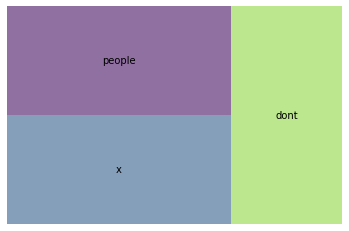

In [253]:
wc_top20 = wc[wc['rank'] <= 10]
print(wc_top20)
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.6)
plt.axis('off')
plt.show()

In [254]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [274]:
df.iloc[88]

text          From hammerl acsu buffalo edu (Valerie S  Hamm...
target                                                       10
text_token    [hammerl, acsu, buffalo, edu, valerie, s, hamm...
Name: 88, dtype: object

In [270]:
#TF-IDF 만들기

def tokenize(document):
    lowercase = document.lower()
    doc = nlp(lowercase)
    return [token.lemma_.strip() for token in doc if token.text not in STOP_WORDS and (token.is_punct != True) and (token.is_alpha == True)]

tfidf_vect = TfidfVectorizer(stop_words = STOP_WORDS,
                             tokenizer = tokenize,
                             ngram_range=(1,2),
                             max_df = 0.7,
                             min_df = 3,
                             max_features=3000)

dtm_tfidf_des = tfidf_vect.fit_transform(df['text'])

dtm_tfidf_des = pd.DataFrame(dtm_tfidf_des.todense(), columns=tfidf_vect.get_feature_names())
dtm_tfidf_des

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'm', 've'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,ab,abc,ability,able,abortion,absolute,absolutely,abuse,ac,...,ysu edu,z,zealand,zero,zip,zone,zoo,zoo toronto,zuma,zuma uucp
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.0,0.0,0.0,0.0,0.053098,0.0,0.0,0.074263,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11311,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11312,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:
from sklearn.neighbors import NearestNeighbors


nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm_tfidf_des)

NearestNeighbors(algorithm='kd_tree')

In [273]:
#88번 문서와 유사한 문서 확인

nn.kneighbors([dtm_tfidf_des.iloc[88]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


(array([[0.        , 0.290277  , 0.73336454, 0.77474519, 0.86657338]]),
 array([[   88, 10200,   911,  7515,  4569]]))